In [1]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer


In [2]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_dim = 2
beta = 1
gamma = 1 
fuzzy_labels = 10 #10 numbers 
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [5]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [6]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [7]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [8]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [9]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [10]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, fuzzy_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.fuzzy_dim = fuzzy_dim
        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(fuzzy_dim, labels_count, trainable=True)
        )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu[:, 0:self.fuzzy_dim])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [11]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [12]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, fuzzy_dim=fuzzy_dim).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,317


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [14]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [15]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:, 0:10].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [16]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)


Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 20.1009 (Recon: 18.0414, KL: 0.1732 Fuzzy: 1.8863) Grad: 13.4792
Step 100 (N samples: 25,600), Loss: 8.4843 (Recon: 7.0585, KL: 0.5077 Fuzzy: 0.9181) Grad: 3.6351
Step 200 (N samples: 51,200), Loss: 8.3554 (Recon: 7.0126, KL: 0.5697 Fuzzy: 0.7731) Grad: 5.5115


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.1557 (BCE: 6.8042, KLD: 0.6182 Fuzzy: 0.7333 Accuracy 0.5612)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.8071 (Recon: 6.5213, KL: 0.6374 Fuzzy: 0.6484) Grad: 3.3963
Step 400 (N samples: 102,400), Loss: 8.0557 (Recon: 6.8264, KL: 0.6148 Fuzzy: 0.6145) Grad: 4.3813


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7926 (BCE: 6.4978, KLD: 0.7384 Fuzzy: 0.5565 Accuracy 0.6231)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.8687 (Recon: 6.5458, KL: 0.7660 Fuzzy: 0.5570) Grad: 3.5907
Step 600 (N samples: 153,600), Loss: 7.7401 (Recon: 6.4728, KL: 0.7360 Fuzzy: 0.5313) Grad: 3.0276
Step 700 (N samples: 179,200), Loss: 7.6235 (Recon: 6.3487, KL: 0.7561 Fuzzy: 0.5186) Grad: 4.4424


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6713 (BCE: 6.3515, KLD: 0.7906 Fuzzy: 0.5291 Accuracy 0.6229)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.5529 (Recon: 6.2446, KL: 0.7903 Fuzzy: 0.5181) Grad: 3.4613
Step 900 (N samples: 230,400), Loss: 7.3587 (Recon: 6.0754, KL: 0.8161 Fuzzy: 0.4673) Grad: 5.8551


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5781 (BCE: 6.2975, KLD: 0.7979 Fuzzy: 0.4826 Accuracy 0.6604)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.4939 (Recon: 6.1936, KL: 0.7956 Fuzzy: 0.5047) Grad: 3.3869
Step 1,100 (N samples: 281,600), Loss: 7.6853 (Recon: 6.3904, KL: 0.8239 Fuzzy: 0.4711) Grad: 2.1243


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5417 (BCE: 6.2171, KLD: 0.8989 Fuzzy: 0.4258 Accuracy 0.7307)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.5662 (Recon: 6.2395, KL: 0.8782 Fuzzy: 0.4485) Grad: 3.7897
Step 1,300 (N samples: 332,800), Loss: 7.8000 (Recon: 6.4114, KL: 0.9305 Fuzzy: 0.4581) Grad: 2.6310
Step 1,400 (N samples: 358,400), Loss: 7.3333 (Recon: 5.9258, KL: 0.9430 Fuzzy: 0.4645) Grad: 2.4791


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5298 (BCE: 6.2063, KLD: 0.9164 Fuzzy: 0.4072 Accuracy 0.7857)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.7501 (Recon: 6.3457, KL: 1.0007 Fuzzy: 0.4037) Grad: 4.6814
Step 1,600 (N samples: 409,600), Loss: 7.6254 (Recon: 6.2802, KL: 0.9272 Fuzzy: 0.4181) Grad: 2.2669


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4478 (BCE: 6.1006, KLD: 0.9649 Fuzzy: 0.3823 Accuracy 0.8142)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.4110 (Recon: 6.0949, KL: 0.9160 Fuzzy: 0.4002) Grad: 2.3213
Step 1,800 (N samples: 460,800), Loss: 7.4986 (Recon: 6.1744, KL: 0.9487 Fuzzy: 0.3756) Grad: 3.0798


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3972 (BCE: 6.1456, KLD: 0.9141 Fuzzy: 0.3375 Accuracy 0.8288)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.3148 (Recon: 6.0777, KL: 0.8983 Fuzzy: 0.3387) Grad: 1.8636
Step 2,000 (N samples: 512,000), Loss: 7.5083 (Recon: 6.2111, KL: 0.9517 Fuzzy: 0.3454) Grad: 2.2928
Step 2,100 (N samples: 537,600), Loss: 7.2332 (Recon: 5.8977, KL: 0.9491 Fuzzy: 0.3865) Grad: 3.2254


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3633 (BCE: 6.0747, KLD: 0.9566 Fuzzy: 0.3321 Accuracy 0.8362)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.3950 (Recon: 6.1464, KL: 0.9414 Fuzzy: 0.3071) Grad: 1.3423
Step 2,300 (N samples: 588,800), Loss: 7.4208 (Recon: 6.0848, KL: 1.0058 Fuzzy: 0.3302) Grad: 2.0467


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3318 (BCE: 6.0342, KLD: 0.9940 Fuzzy: 0.3036 Accuracy 0.8586)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.4274 (Recon: 6.1060, KL: 0.9927 Fuzzy: 0.3287) Grad: 2.4558
Step 2,500 (N samples: 640,000), Loss: 7.4315 (Recon: 6.1560, KL: 0.9380 Fuzzy: 0.3376) Grad: 2.3924


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3542 (BCE: 6.1033, KLD: 0.9532 Fuzzy: 0.2977 Accuracy 0.8924)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.1714 (Recon: 5.8668, KL: 0.9879 Fuzzy: 0.3168) Grad: 1.8826
Step 2,700 (N samples: 691,200), Loss: 7.1707 (Recon: 5.9438, KL: 0.9839 Fuzzy: 0.2431) Grad: 1.3353
Step 2,800 (N samples: 716,800), Loss: 7.2004 (Recon: 5.9096, KL: 0.9771 Fuzzy: 0.3137) Grad: 2.0785


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2687 (BCE: 6.0224, KLD: 0.9806 Fuzzy: 0.2656 Accuracy 0.9157)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.3383 (Recon: 6.1483, KL: 0.9178 Fuzzy: 0.2722) Grad: 2.5125
Step 3,000 (N samples: 768,000), Loss: 7.3213 (Recon: 6.0048, KL: 1.0517 Fuzzy: 0.2648) Grad: 2.8224


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3019 (BCE: 6.0506, KLD: 0.9898 Fuzzy: 0.2615 Accuracy 0.9280)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.2429 (Recon: 6.0118, KL: 0.9923 Fuzzy: 0.2388) Grad: 2.0248
Step 3,200 (N samples: 819,200), Loss: 7.4528 (Recon: 6.1427, KL: 1.0608 Fuzzy: 0.2493) Grad: 2.0659


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2498 (BCE: 6.0049, KLD: 1.0084 Fuzzy: 0.2365 Accuracy 0.9358)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.1999 (Recon: 5.9320, KL: 1.0357 Fuzzy: 0.2323) Grad: 2.4817
Step 3,400 (N samples: 870,400), Loss: 7.3254 (Recon: 6.0719, KL: 1.0381 Fuzzy: 0.2154) Grad: 1.6551
Step 3,500 (N samples: 896,000), Loss: 7.0778 (Recon: 5.8295, KL: 0.9967 Fuzzy: 0.2517) Grad: 1.9280


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2292 (BCE: 5.9710, KLD: 1.0394 Fuzzy: 0.2187 Accuracy 0.9396)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.1682 (Recon: 5.9057, KL: 1.0221 Fuzzy: 0.2404) Grad: 2.5248
Step 3,700 (N samples: 947,200), Loss: 7.4694 (Recon: 6.1837, KL: 0.9769 Fuzzy: 0.3088) Grad: 2.4867


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2272 (BCE: 5.9809, KLD: 1.0246 Fuzzy: 0.2217 Accuracy 0.9453)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.3440 (Recon: 6.0702, KL: 1.0458 Fuzzy: 0.2280) Grad: 2.7536
Step 3,900 (N samples: 998,400), Loss: 7.2841 (Recon: 6.0740, KL: 1.0137 Fuzzy: 0.1964) Grad: 2.1915


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2366 (BCE: 6.0308, KLD: 0.9957 Fuzzy: 0.2101 Accuracy 0.9451)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.2834 (Recon: 6.0108, KL: 1.0484 Fuzzy: 0.2242) Grad: 2.5989
Step 4,100 (N samples: 1,049,600), Loss: 7.1525 (Recon: 5.8852, KL: 1.0260 Fuzzy: 0.2413) Grad: 2.4931
Step 4,200 (N samples: 1,075,200), Loss: 7.3331 (Recon: 6.0744, KL: 1.0119 Fuzzy: 0.2468) Grad: 2.0441


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2718 (BCE: 5.9891, KLD: 1.0583 Fuzzy: 0.2243 Accuracy 0.9464)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.5183 (Recon: 6.2543, KL: 1.0024 Fuzzy: 0.2616) Grad: 3.1844
Step 4,400 (N samples: 1,126,400), Loss: 7.3062 (Recon: 6.0669, KL: 0.9995 Fuzzy: 0.2398) Grad: 2.0552


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2045 (BCE: 5.9448, KLD: 1.0483 Fuzzy: 0.2115 Accuracy 0.9497)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.1538 (Recon: 5.9321, KL: 1.0159 Fuzzy: 0.2057) Grad: 1.8288
Step 4,600 (N samples: 1,177,600), Loss: 7.3809 (Recon: 6.1275, KL: 1.0345 Fuzzy: 0.2190) Grad: 1.9086


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2079 (BCE: 5.9792, KLD: 1.0271 Fuzzy: 0.2016 Accuracy 0.9498)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.2184 (Recon: 5.9852, KL: 1.0197 Fuzzy: 0.2135) Grad: 2.4702
Step 4,800 (N samples: 1,228,800), Loss: 7.4082 (Recon: 6.0891, KL: 1.0804 Fuzzy: 0.2388) Grad: 1.8971
Step 4,900 (N samples: 1,254,400), Loss: 7.2598 (Recon: 6.0140, KL: 1.0243 Fuzzy: 0.2215) Grad: 1.8172


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2086 (BCE: 5.9685, KLD: 1.0325 Fuzzy: 0.2077 Accuracy 0.9511)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.3142 (Recon: 6.0906, KL: 1.0444 Fuzzy: 0.1792) Grad: 3.3791
Step 5,100 (N samples: 1,305,600), Loss: 7.2684 (Recon: 6.0354, KL: 1.0207 Fuzzy: 0.2124) Grad: 2.0036


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1879 (BCE: 5.9292, KLD: 1.0480 Fuzzy: 0.2107 Accuracy 0.9491)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.3834 (Recon: 6.1222, KL: 1.0426 Fuzzy: 0.2186) Grad: 1.7265
Step 5,300 (N samples: 1,356,800), Loss: 7.0843 (Recon: 5.8595, KL: 1.0228 Fuzzy: 0.2021) Grad: 2.1101
Step 5,400 (N samples: 1,382,400), Loss: 7.2565 (Recon: 6.0126, KL: 1.0216 Fuzzy: 0.2222) Grad: 1.8646


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1990 (BCE: 5.9867, KLD: 1.0094 Fuzzy: 0.2029 Accuracy 0.9518)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.3731 (Recon: 6.0505, KL: 1.0893 Fuzzy: 0.2333) Grad: 1.9095
Step 5,600 (N samples: 1,433,600), Loss: 7.1621 (Recon: 5.8771, KL: 1.0726 Fuzzy: 0.2124) Grad: 2.5804


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1831 (BCE: 5.9208, KLD: 1.0683 Fuzzy: 0.1939 Accuracy 0.9563)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.5716 (Recon: 6.2730, KL: 1.0657 Fuzzy: 0.2329) Grad: 3.8830
Step 5,800 (N samples: 1,484,800), Loss: 7.1495 (Recon: 5.9262, KL: 1.0007 Fuzzy: 0.2225) Grad: 2.1907


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1579 (BCE: 5.9195, KLD: 1.0477 Fuzzy: 0.1907 Accuracy 0.9575)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.2883 (Recon: 6.0259, KL: 1.0286 Fuzzy: 0.2338) Grad: 3.4051
Step 6,000 (N samples: 1,536,000), Loss: 7.3392 (Recon: 6.0664, KL: 1.0693 Fuzzy: 0.2034) Grad: 2.1405
Step 6,100 (N samples: 1,561,600), Loss: 7.2109 (Recon: 5.9134, KL: 1.0586 Fuzzy: 0.2390) Grad: 2.4594


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1983 (BCE: 5.9277, KLD: 1.0673 Fuzzy: 0.2032 Accuracy 0.9541)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.1183 (Recon: 5.8440, KL: 1.0863 Fuzzy: 0.1880) Grad: 1.6974
Step 6,300 (N samples: 1,612,800), Loss: 7.2449 (Recon: 6.0281, KL: 1.0198 Fuzzy: 0.1970) Grad: 1.6617


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1772 (BCE: 5.9484, KLD: 1.0399 Fuzzy: 0.1889 Accuracy 0.9563)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.3074 (Recon: 5.9890, KL: 1.1134 Fuzzy: 0.2051) Grad: 2.1225
Step 6,500 (N samples: 1,664,000), Loss: 7.1624 (Recon: 5.8907, KL: 1.0576 Fuzzy: 0.2140) Grad: 1.6837


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1832 (BCE: 5.9353, KLD: 1.0536 Fuzzy: 0.1943 Accuracy 0.9545)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.0792 (Recon: 5.8247, KL: 1.0553 Fuzzy: 0.1992) Grad: 1.9523
Step 6,700 (N samples: 1,715,200), Loss: 7.1760 (Recon: 5.9194, KL: 1.0576 Fuzzy: 0.1990) Grad: 1.7695
Step 6,800 (N samples: 1,740,800), Loss: 7.1086 (Recon: 5.8561, KL: 1.0424 Fuzzy: 0.2102) Grad: 2.4804


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1474 (BCE: 5.8977, KLD: 1.0615 Fuzzy: 0.1883 Accuracy 0.9576)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.2691 (Recon: 6.0057, KL: 1.0646 Fuzzy: 0.1988) Grad: 1.8535
Step 7,000 (N samples: 1,792,000), Loss: 7.1023 (Recon: 5.8532, KL: 1.0662 Fuzzy: 0.1828) Grad: 2.2237


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1583 (BCE: 5.9069, KLD: 1.0670 Fuzzy: 0.1844 Accuracy 0.9583)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.0790 (Recon: 5.8027, KL: 1.0891 Fuzzy: 0.1873) Grad: 1.9641
Step 7,200 (N samples: 1,843,200), Loss: 7.2458 (Recon: 5.9757, KL: 1.0723 Fuzzy: 0.1979) Grad: 2.6476


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1430 (BCE: 5.8765, KLD: 1.0811 Fuzzy: 0.1854 Accuracy 0.9587)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.1060 (Recon: 5.8214, KL: 1.0795 Fuzzy: 0.2051) Grad: 2.4085
Step 7,400 (N samples: 1,894,400), Loss: 7.2989 (Recon: 6.0282, KL: 1.0514 Fuzzy: 0.2192) Grad: 1.9238
Step 7,500 (N samples: 1,920,000), Loss: 7.1584 (Recon: 5.8919, KL: 1.0716 Fuzzy: 0.1949) Grad: 1.4750


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1710 (BCE: 5.9665, KLD: 1.0159 Fuzzy: 0.1886 Accuracy 0.9580)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.0970 (Recon: 5.8375, KL: 1.0794 Fuzzy: 0.1801) Grad: 1.4710
Step 7,700 (N samples: 1,971,200), Loss: 7.3164 (Recon: 6.0003, KL: 1.1009 Fuzzy: 0.2152) Grad: 2.2294


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1619 (BCE: 5.8756, KLD: 1.1060 Fuzzy: 0.1803 Accuracy 0.9595)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.0593 (Recon: 5.7879, KL: 1.0833 Fuzzy: 0.1881) Grad: 1.8424
Step 7,900 (N samples: 2,022,400), Loss: 7.1316 (Recon: 5.9001, KL: 1.0649 Fuzzy: 0.1666) Grad: 1.3184


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1830 (BCE: 5.8787, KLD: 1.1097 Fuzzy: 0.1946 Accuracy 0.9562)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.3232 (Recon: 6.0718, KL: 1.0406 Fuzzy: 0.2108) Grad: 3.3950
Step 8,100 (N samples: 2,073,600), Loss: 7.2816 (Recon: 6.0011, KL: 1.0977 Fuzzy: 0.1828) Grad: 1.8176
Step 8,200 (N samples: 2,099,200), Loss: 7.1068 (Recon: 5.8173, KL: 1.0919 Fuzzy: 0.1977) Grad: 2.0914


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1340 (BCE: 5.8249, KLD: 1.1331 Fuzzy: 0.1760 Accuracy 0.9576)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.2707 (Recon: 5.9711, KL: 1.0948 Fuzzy: 0.2048) Grad: 2.1335
Step 8,400 (N samples: 2,150,400), Loss: 7.3644 (Recon: 6.0793, KL: 1.1094 Fuzzy: 0.1757) Grad: 1.7172


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1299 (BCE: 5.8791, KLD: 1.0740 Fuzzy: 0.1769 Accuracy 0.9604)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.0429 (Recon: 5.7453, KL: 1.1216 Fuzzy: 0.1760) Grad: 2.0264
Step 8,600 (N samples: 2,201,600), Loss: 7.2870 (Recon: 6.0214, KL: 1.0808 Fuzzy: 0.1848) Grad: 1.7002


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1233 (BCE: 5.8397, KLD: 1.1120 Fuzzy: 0.1716 Accuracy 0.9598)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.3455 (Recon: 6.0453, KL: 1.1184 Fuzzy: 0.1817) Grad: 2.1053
Step 8,800 (N samples: 2,252,800), Loss: 7.1438 (Recon: 5.8434, KL: 1.1106 Fuzzy: 0.1898) Grad: 2.1504
Step 8,900 (N samples: 2,278,400), Loss: 7.1853 (Recon: 5.8897, KL: 1.1140 Fuzzy: 0.1816) Grad: 2.2330


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1217 (BCE: 5.8234, KLD: 1.1209 Fuzzy: 0.1774 Accuracy 0.9612)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.3674 (Recon: 6.0566, KL: 1.0915 Fuzzy: 0.2193) Grad: 2.7815
Step 9,100 (N samples: 2,329,600), Loss: 7.0902 (Recon: 5.8016, KL: 1.1103 Fuzzy: 0.1783) Grad: 1.8011


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1071 (BCE: 5.8408, KLD: 1.0984 Fuzzy: 0.1679 Accuracy 0.9593)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.2389 (Recon: 5.9815, KL: 1.1079 Fuzzy: 0.1495) Grad: 1.0457
Step 9,300 (N samples: 2,380,800), Loss: 7.2935 (Recon: 6.0161, KL: 1.0991 Fuzzy: 0.1782) Grad: 2.1963


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1155 (BCE: 5.8517, KLD: 1.0927 Fuzzy: 0.1711 Accuracy 0.9588)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.1073 (Recon: 5.8449, KL: 1.0954 Fuzzy: 0.1670) Grad: 1.8964
Step 9,500 (N samples: 2,432,000), Loss: 7.0562 (Recon: 5.7910, KL: 1.1198 Fuzzy: 0.1454) Grad: 1.2221
Step 9,600 (N samples: 2,457,600), Loss: 6.9933 (Recon: 5.6772, KL: 1.1164 Fuzzy: 0.1998) Grad: 2.3918


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1234 (BCE: 5.9042, KLD: 1.0577 Fuzzy: 0.1615 Accuracy 0.9633)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.1813 (Recon: 5.9315, KL: 1.0901 Fuzzy: 0.1597) Grad: 2.6653
Step 9,800 (N samples: 2,508,800), Loss: 7.1835 (Recon: 5.9027, KL: 1.1263 Fuzzy: 0.1544) Grad: 1.6707


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1083 (BCE: 5.8241, KLD: 1.1145 Fuzzy: 0.1696 Accuracy 0.9612)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.1935 (Recon: 5.9419, KL: 1.0819 Fuzzy: 0.1698) Grad: 2.0027
Step 10,000 (N samples: 2,560,000), Loss: 7.0804 (Recon: 5.8144, KL: 1.0862 Fuzzy: 0.1797) Grad: 2.0250
Step 10,100 (N samples: 2,585,600), Loss: 7.2193 (Recon: 5.9376, KL: 1.1069 Fuzzy: 0.1748) Grad: 1.9773


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1098 (BCE: 5.8137, KLD: 1.1346 Fuzzy: 0.1615 Accuracy 0.9628)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.1310 (Recon: 5.8494, KL: 1.1306 Fuzzy: 0.1509) Grad: 1.2121
Step 10,300 (N samples: 2,636,800), Loss: 7.0382 (Recon: 5.7624, KL: 1.1057 Fuzzy: 0.1702) Grad: 2.5529


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1304 (BCE: 5.8493, KLD: 1.1236 Fuzzy: 0.1575 Accuracy 0.9633)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.0012 (Recon: 5.7297, KL: 1.1226 Fuzzy: 0.1489) Grad: 1.8290
Step 10,500 (N samples: 2,688,000), Loss: 7.1763 (Recon: 5.8872, KL: 1.0776 Fuzzy: 0.2114) Grad: 2.7403


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1317 (BCE: 5.8731, KLD: 1.0917 Fuzzy: 0.1669 Accuracy 0.9646)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.1514 (Recon: 5.8307, KL: 1.1156 Fuzzy: 0.2051) Grad: 2.7870
Step 10,700 (N samples: 2,739,200), Loss: 7.0591 (Recon: 5.7831, KL: 1.1340 Fuzzy: 0.1419) Grad: 1.4306
Step 10,800 (N samples: 2,764,800), Loss: 7.2671 (Recon: 5.9946, KL: 1.1087 Fuzzy: 0.1638) Grad: 2.4856


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1148 (BCE: 5.8547, KLD: 1.0994 Fuzzy: 0.1608 Accuracy 0.9624)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.2362 (Recon: 5.9586, KL: 1.0857 Fuzzy: 0.1919) Grad: 2.1996
Step 11,000 (N samples: 2,816,000), Loss: 7.2158 (Recon: 5.9370, KL: 1.1126 Fuzzy: 0.1662) Grad: 1.7245


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1043 (BCE: 5.8483, KLD: 1.0992 Fuzzy: 0.1568 Accuracy 0.9646)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 6.9701 (Recon: 5.6627, KL: 1.1283 Fuzzy: 0.1791) Grad: 2.4481
Step 11,200 (N samples: 2,867,200), Loss: 7.2695 (Recon: 5.9560, KL: 1.1368 Fuzzy: 0.1767) Grad: 2.3703


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1281 (BCE: 5.8302, KLD: 1.1267 Fuzzy: 0.1712 Accuracy 0.9626)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.1581 (Recon: 5.8661, KL: 1.1129 Fuzzy: 0.1790) Grad: 2.3663
Step 11,400 (N samples: 2,918,400), Loss: 7.0768 (Recon: 5.7541, KL: 1.1308 Fuzzy: 0.1919) Grad: 3.0403
Step 11,500 (N samples: 2,944,000), Loss: 6.9209 (Recon: 5.6515, KL: 1.1121 Fuzzy: 0.1574) Grad: 2.4733


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1125 (BCE: 5.8091, KLD: 1.1424 Fuzzy: 0.1610 Accuracy 0.9615)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 7.2179 (Recon: 5.9230, KL: 1.1473 Fuzzy: 0.1476) Grad: 2.1893
Step 11,700 (N samples: 2,995,200), Loss: 7.0250 (Recon: 5.7036, KL: 1.1269 Fuzzy: 0.1945) Grad: 2.2317


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.0906 (BCE: 5.8364, KLD: 1.1037 Fuzzy: 0.1504 Accuracy 0.9648)


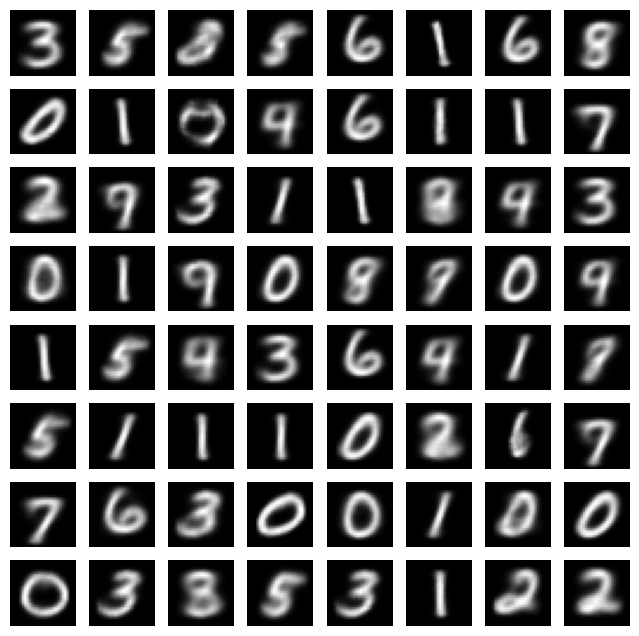

In [17]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [18]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, logvar, z, labels = model.half_pass(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:10].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:10].cpu().numpy(), axis=1))

z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [35]:
from collections import defaultdict

data_centroids_dict = defaultdict(list)

for mu, y in zip(z_all, pred_y_all):
    data_centroids_dict[y].append(mu)

cluster_centroids_from_data = []

for numb in range(0,10):
    cluster_centroids_from_data.append(np.mean(data_centroids_dict[numb], axis=0))


cluster_centroids_from_data

[array([ 1. , -0.8], dtype=float32),
 array([-1.2,  0. ], dtype=float32),
 array([ 0.6, -0.1], dtype=float32),
 array([0.6, 0.5], dtype=float32),
 array([-0. , -0.3], dtype=float32),
 array([-0.1,  0.5], dtype=float32),
 array([0. , 1.3], dtype=float32),
 array([-0.4, -1. ], dtype=float32),
 array([-0. ,  0.2], dtype=float32),
 array([-0.2, -0.5], dtype=float32)]

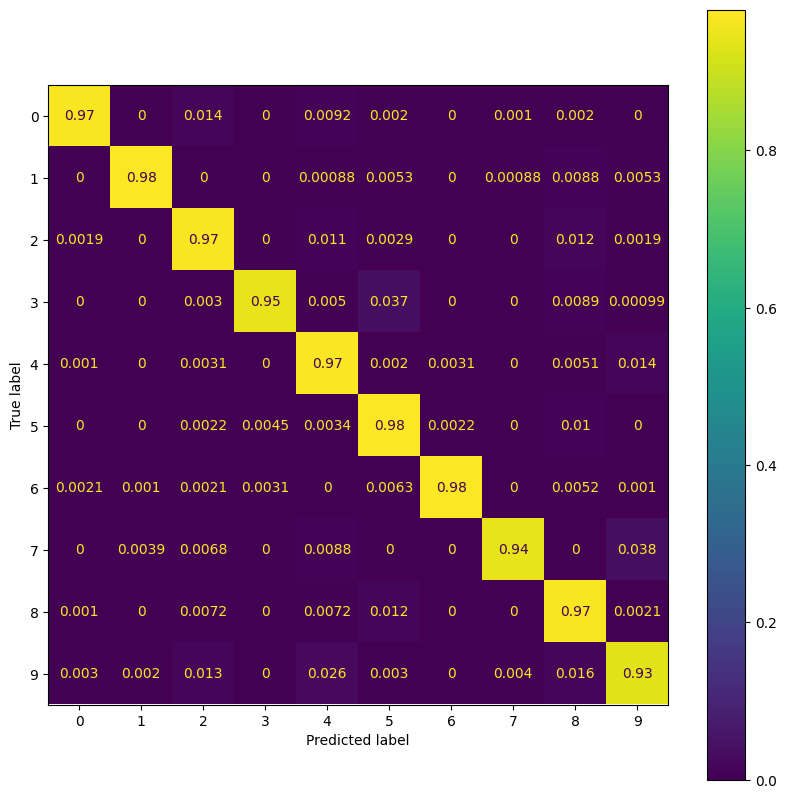

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

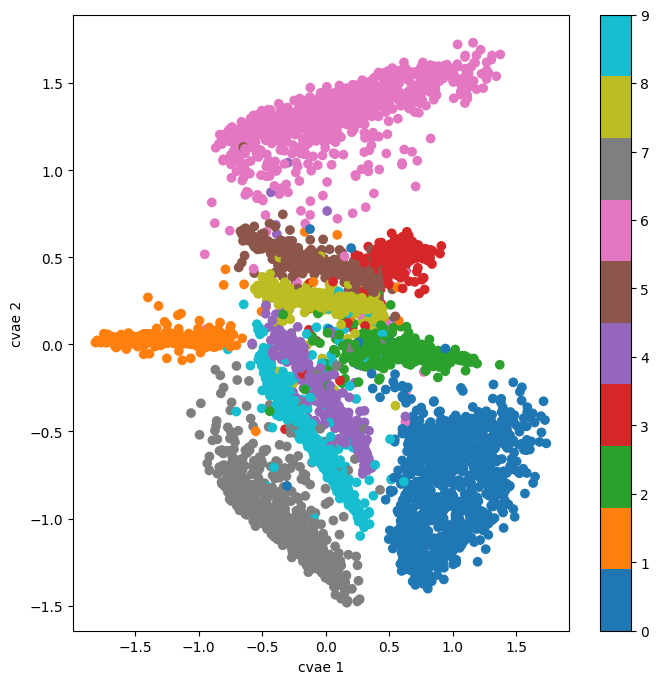

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")

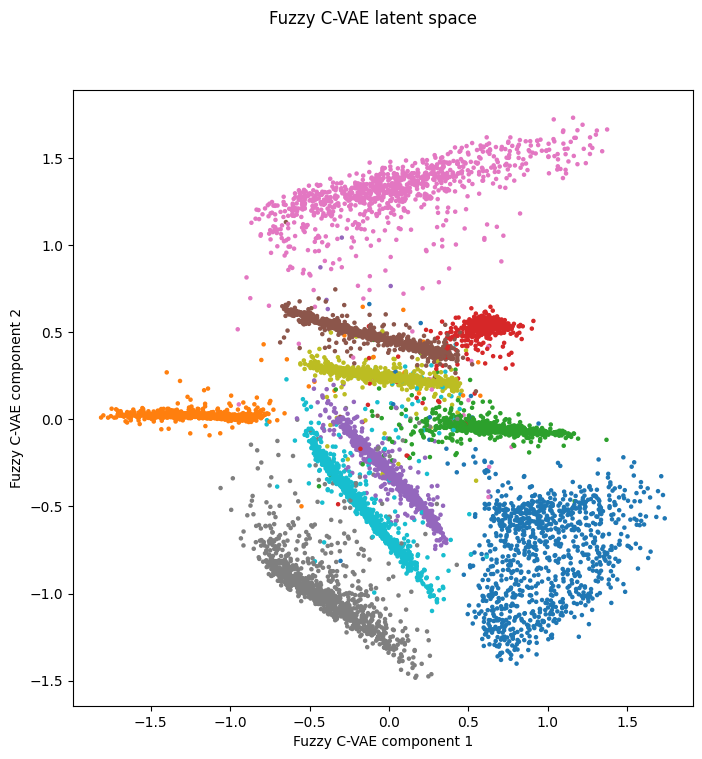

In [22]:
mask = "Fuzzy C-VAE"
if not is_fuzzy_loss_active:
    mask = "VAE"
import matplotlib.colors
# figure, axis = plt.subplots(2, 3, figsize=(17, 10)) 
# axis[0][0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
# axis[0][0].set_title("")
# axis[0][0].set_xlabel(f"{mask} component 1")
# axis[0][0].set_ylabel(f"{mask} component 2")


plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=5)
plt.xlabel(f"{mask} component 1")
plt.ylabel(f"{mask} component 2")
plt.suptitle(f'{mask} latent space')
if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig2b-fcvae-all-features.eps', format='eps')
else:
    plt.savefig('papers/iiti24/fig2a-vae-all-features.eps', format='eps')
plt.show()


In [23]:
domains_scatter_points = []
for x in np.linspace(-1.9, 2.0, 200):
    for y in np.linspace(-1.2, 2, 200):
        fuzzy_inference = model.fuzzy.forward(torch.FloatTensor([[x,y]]).to(device)).cpu().detach().numpy()
        fuzzy_class =np.argmax(fuzzy_inference[0,0:10])
        domains_scatter_points.append([x,y,fuzzy_class])

domains_scatter_points = np.array(domains_scatter_points)

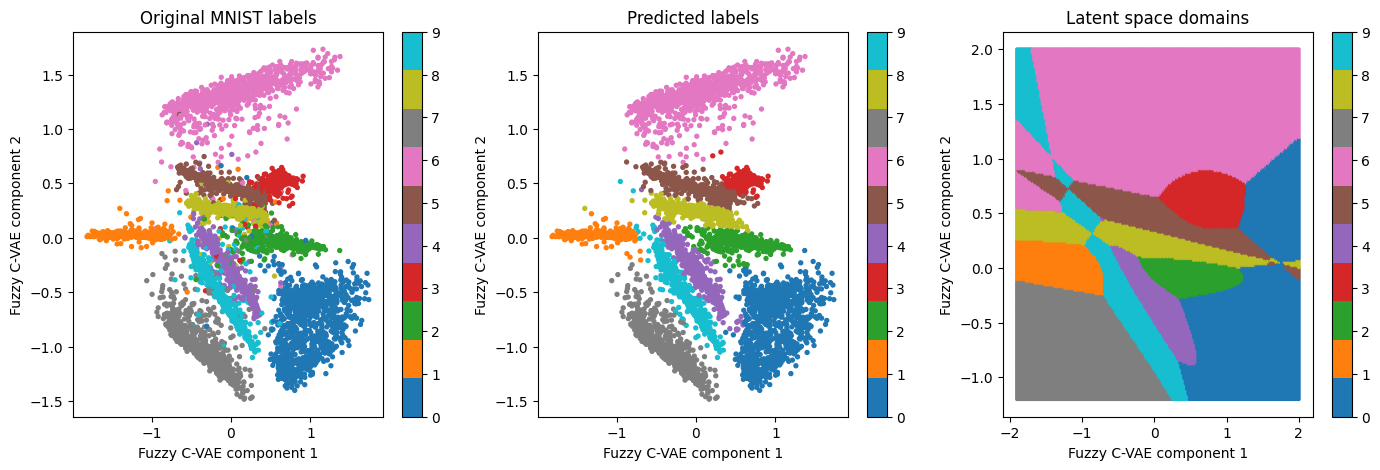

In [24]:
import matplotlib.colors
figure, axis = plt.subplots(1, 3, figsize=(17, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Original MNIST labels")
axis[0].set_xlabel(f"{mask} component 1")
axis[0].set_ylabel(f"{mask} component 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Predicted labels") 
axis[1].set_xlabel(f"{mask} component 1")
axis[1].set_ylabel(f"{mask} component 2")
tmm_cmap = matplotlib.colors.ListedColormap(['red', 'green'])

sc3 = axis[2].scatter(domains_scatter_points[:, 0], domains_scatter_points[:, 1], c = domains_scatter_points[:, 2], s=3, cmap='tab10')
axis[2].set_title("Latent space domains") 
axis[2].set_xlabel(f"{mask} component 1")
axis[2].set_ylabel(f"{mask} component 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)

if is_fuzzy_loss_active:
    plt.savefig('papers/iiti24/fig3-fcvae-classification.eps', format="eps")
plt.show()

## Data generation

torch.Size([10, 2])


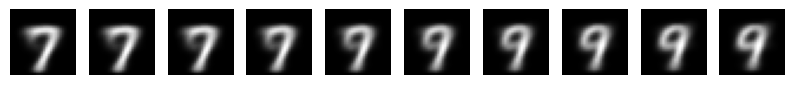

In [25]:
n = 10
path_from_4_to_9 = np.linspace(cluster_centroids_from_data[7], cluster_centroids_from_data[9], n)
path_from_4_to_9 = [torch.FloatTensor(a) for a in path_from_4_to_9]

z = torch.stack(path_from_4_to_9, dim=0).to(device)
print(z.shape)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('papers/iiti24/fig4-sample-generation.eps', format="eps")
plt.show()


tensor([[ 0.5519, -0.0458]], device='cuda:0', grad_fn=<SplitBackward>)
[[0.1 0.1 0.8 0.1 0.  0.  0.  0.  0.1 0. ]]


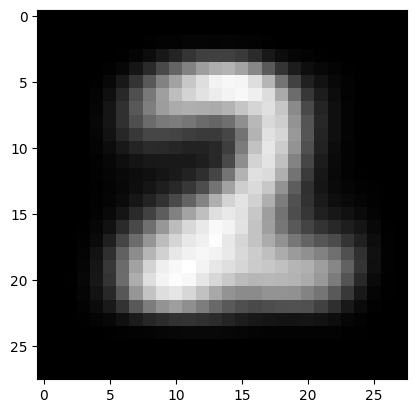

In [26]:

mu, std, z, fz = model.half_pass(test_data[1][0].reshape((1,1,28,28)).to(device))

# mu[0][0] = -2.8242958
# mu[0][1] = -0.39727297

print(mu)
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)
print(fz.cpu().detach().numpy())
samples = model.decoder_pass(mu)
#samples = torch.sigmoid(samples)
plt.imshow(samples[0].view(28, 28).cpu().detach().numpy(), cmap='gray')
    

## Anomaly detection

In [27]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [28]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]

len(emnist_x)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_7036\2301690307.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32) for a in emnist_x]


103600

In [29]:
emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))
emnist_mapping

{1: 'Aa',
 2: 'Bb',
 3: 'Cc',
 4: 'Dd',
 5: 'Ee',
 6: 'Ff',
 7: 'Gg',
 8: 'Hh',
 9: 'Ii',
 10: 'Jj',
 11: 'Kk',
 12: 'Ll',
 13: 'Mm',
 14: 'Nn',
 15: 'Oo',
 16: 'Pp',
 17: 'Qq',
 18: 'Rr',
 19: 'Ss',
 20: 'Tt',
 21: 'Uu',
 22: 'Vv',
 23: 'Ww',
 24: 'Xx',
 25: 'Yy',
 26: 'Zz'}

In [69]:
model.eval()

anomaly_mu = defaultdict(list)


with torch.no_grad():
    for data, label in zip(emnist_x, emnist_y):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        
        anomaly_mu[emnist_mapping[label]].append(mu.cpu().numpy())

anomaly_mu

defaultdict(list,
            {'Aa': [array([[ 0.2, -0. ]], dtype=float32),
              array([[0.1, 0.1]], dtype=float32),
              array([[ 0.5, -0.6]], dtype=float32),
              array([[ 0.9, -0.8]], dtype=float32),
              array([[ 0.2, -0.5]], dtype=float32),
              array([[ 0.2, -0.2]], dtype=float32),
              array([[ 0.2, -0.5]], dtype=float32),
              array([[ 0.3, -0.3]], dtype=float32),
              array([[ 0.4, -0.4]], dtype=float32),
              array([[ 0.2, -0.3]], dtype=float32),
              array([[-0.3,  0.8]], dtype=float32),
              array([[ 0.3, -0.3]], dtype=float32),
              array([[ 1. , -0.9]], dtype=float32),
              array([[ 0.6, -0.3]], dtype=float32),
              array([[-0.1,  0.5]], dtype=float32),
              array([[ 0.2, -0.1]], dtype=float32),
              array([[ 0.3, -0.6]], dtype=float32),
              array([[ 0.4, -0.1]], dtype=float32),
              array([[ 0.4, -0.4]], dtype=

In [108]:
from sklearn.ensemble import IsolationForest

detectors = {}

for numb in range(0,10):
    isolf = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0)
    isolf.fit(data_centroids_dict[numb])
    detectors[numb] = isolf

anomaly_rates = {}
for letters_pair in emnist_mapping.values():
   
    input = np.reshape(anomaly_mu[letters_pair],(len(anomaly_mu[letters_pair]),2))

    scores = [detectors[a].predict(input) for a in range(0, 10)]

    overall_score = np.max(scores,axis = 0)
    overall_score = [1 if a==-1 else 0 for a in overall_score]

    #unique, counts = np.unique(, return_counts=True)
    #rates = dict(zip(unique, counts))
    anomaly_rates[letters_pair] = (np.mean(overall_score), np.std(overall_score))


In [111]:
scores = [detectors[a].predict(z_all) for a in range(0, 10)]

numbers_score = np.max(scores,axis = 0)
numbers_score = [1 if a==-1 else 0 for a in numbers_score]

print(f"Anomality rate on pure numbers {np.mean(numbers_score)}" )

Anomality rate on pure numbers 0.1782


In [112]:
anomaly_stats = []

anomaly_stats.append(
    {
            'Letters': '0123456789',
            'Anomaly rate': np.mean(numbers_score),
    }
)

for k in anomaly_rates.keys():
    anomaly_stats.append(
        {
            'Letters': k,
            'Detected anomaly rate': anomaly_rates[k][0],
        }
    )


pd.DataFrame(anomaly_stats).sort_values('Detected anomaly rate')

,Letters,Detected anomaly rate
0,0123456789,0.178200
15,Oo,0.360741
23,Ww,0.394099
14,Nn,0.612965
13,Mm,0.620419
9,Ii,0.632923
6,Ff,0.647115
22,Vv,0.663063
21,Uu,0.686166
12,Ll,0.702254


In [121]:
latex_table = pd.DataFrame(anomaly_stats, index=None).sort_values('Detected anomaly rate').to_latex( escape = False,index=False, float_format="{:.2f}".format)
print(latex_table)

\begin{tabular}{lr}
\toprule
Letters & Detected anomaly rate \\
\midrule
0123456789 & 0.18 \\
Oo & 0.36 \\
Ww & 0.39 \\
Nn & 0.61 \\
Mm & 0.62 \\
Ii & 0.63 \\
Ff & 0.65 \\
Vv & 0.66 \\
Uu & 0.69 \\
Ll & 0.70 \\
Aa & 0.71 \\
Pp & 0.71 \\
Tt & 0.73 \\
Dd & 0.75 \\
Gg & 0.76 \\
Qq & 0.76 \\
Yy & 0.78 \\
Bb & 0.79 \\
Kk & 0.79 \\
Cc & 0.80 \\
Hh & 0.81 \\
Ee & 0.82 \\
Ss & 0.82 \\
Rr & 0.83 \\
Jj & 0.85 \\
Zz & 0.86 \\
Xx & 0.89 \\
\bottomrule
\end{tabular}



tensor([0.0391, 0.0243, 0.0893, 0.1120, 0.1662, 0.1667, 0.0486, 0.0140, 0.5863,
        0.0116], device='cuda:0')
tensor(0.5863, device='cuda:0')


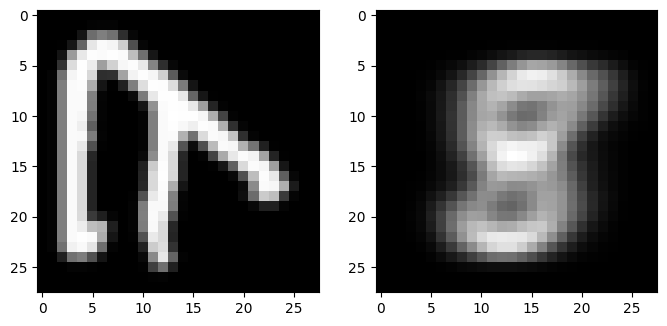

In [ ]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    data = emnist_x[4009]
    data = data.view((-1,1,28,28)).to(device)
    mu, x_recon, flabels= model.forward(data)
    print(flabels[0])
    print(flabels[0][0:10].max())
    ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')